## Learning Outcomes
1. Image histogram : distribution grayscale values
2. Enhance contrast : scalar multiplication of image, histogram equalization and its variant called CLAHE.
3. Thresholding : global thresholding and otsu thresholding
4. Morphological operations (limit our discussion on binary image)
5. Color spaces : HSV color space used to perform color based segmentation

## Setup

In [3]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

## Image histogram

### Purpose of Image Histogram
Purposes:
- know the distribution of grayscale values/pixel
- use case
    - histogram equalization
        - help to enhance contrast
        - normally done before edge detection
        - probability density function
    - build image (color histogram) search engine

In [2]:
img = cv.imread("images/lena.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [3]:
# There are 2 ways to compute histogram
%timeit hist = cv.calcHist([gray], [0], None, [256], [0, 256])
%timeit hist, _ = np.histogram(gray.flatten(), 256)

#256: number of bins

101 µs ± 900 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
3.09 ms ± 273 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


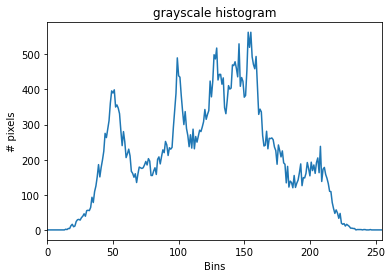

In [4]:
hist = cv.calcHist([gray], [0], None, [256], [0, 256])

plt.figure()
plt.title("grayscale histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.plot(hist)
plt.xlim([0, 255])
plt.show()

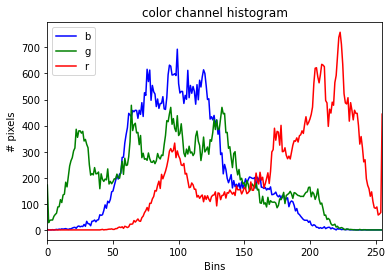

In [5]:
# get the histogram for every channel
channels = cv.split(img)
colors = ["b", "g", "r"]

plt.figure()
plt.title("color channel histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")

for ch, color in zip(channels, colors):
    hist = cv.calcHist([ch], [0], None, [256], [0, 256])
    plt.plot(hist, color=color, label=color)
    
plt.xlim([0, 255])
plt.legend()
plt.show()

In [7]:
img = cv.imread("images/low_contrast_img.jfif", 0)
show_img("low contrast", img)

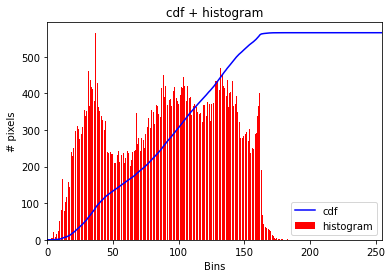

In [8]:
# histogram for this image
hist = cv.calcHist([img], [0], None, [256], [0, 256])

# cumulative distribution function (cdf)
cdf = hist.cumsum()
cdf_norm = cdf * hist.max() / cdf.max()

plt.figure()
plt.plot(cdf_norm, color="b")
plt.hist(img.flatten(), 256, color="r")
plt.title("cdf + histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.legend(("cdf", "histogram"))
plt.xlim([0, 255])
plt.show()

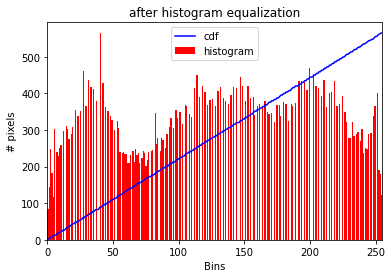

In [9]:
# histogram equalization
eq = cv.equalizeHist(img)

hist = cv.calcHist([eq], [0], None, [256], [0, 256])
cdf = hist.cumsum()
cdf_norm = cdf * hist.max() / cdf.max()

plt.figure()
plt.plot(cdf_norm, color="b")
plt.hist(eq.flatten(), 256, color="r")
plt.title("after histogram equalization")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.legend(("cdf", "histogram"))
plt.xlim([0, 255])
plt.show()

In [10]:
# CLAHE
img = cv.imread("images/dog1.jfif", 0)

# equalization
eq = cv.equalizeHist(img)
# CLAHE
clahe = cv.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
dst = clahe.apply(img)

cv.imshow("original", img)
cv.imshow("equalization", dst)
show_img("clahe", eq)
cv.waitKey(0)
cv.destroyAllWindows()

## Exercise 1
Try histogram equalization and CLAHE on "winter.jfif" and display the results together with the original grayscale image. Comment on the results obtained

In [777]:
img = cv.imread("images/winter.jfif", 0)

# equalization
eq = cv.equalizeHist(img)
# CLAHE
clahe = cv.createCLAHE(clipLimit=4, tileGridSize=(9, 9))
dst = clahe.apply(img)

cv.imshow("original", img)
cv.imshow("equalization", dst)
show_img("clahe", eq)
cv.waitKey(0)
cv.destroyAllWindows()

## Thresholding

In [778]:
# simple global thresholding
# different types of thresholding
[i for i in dir(cv) if i.startswith("THRESH")]

['THRESH_BINARY',
 'THRESH_BINARY_INV',
 'THRESH_MASK',
 'THRESH_OTSU',
 'THRESH_TOZERO',
 'THRESH_TOZERO_INV',
 'THRESH_TRIANGLE',
 'THRESH_TRUNC']

In [779]:
img = np.fromfunction(lambda i, j: j, (50, 256), dtype=np.uint8)

def trackbar(x):
    _, img1 = cv.threshold(img, x, 255, cv.THRESH_BINARY)
    _, img2 = cv.threshold(img, x, 255, cv.THRESH_BINARY_INV)
    _, img3 = cv.threshold(img, x, 255, cv.THRESH_TRUNC)
    _, img4 = cv.threshold(img, x, 255, cv.THRESH_TOZERO)
    _, img5 = cv.threshold(img, x, 255, cv.THRESH_TOZERO_INV)
    
    cv.imshow("window", np.vstack((img1, img2, img3, img4, img5)))
    
cv.namedWindow("window")
cv.createTrackbar("threshold", "window", 100, 255, trackbar)

cv.waitKey(0)
cv.destroyAllWindows()

## Simple global threshold vs Otsu thresholding

Assumption of Otsu thresholding:
- works best if histogram is bimodel distribution

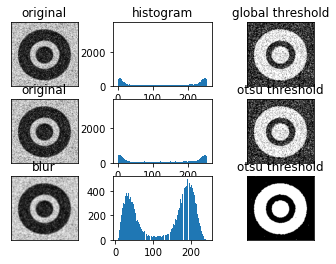

In [14]:
# apply 3 approaches: 1. global threshold, 2. Otsu threshold, 3. blurring + otsu
img = cv.imread("images/noisy.jfif", 0)

#show_img("noisy", img)

#1:
# render darker region to become lighter
th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)[1]

#2
th2 = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

#3
blur = cv.GaussianBlur(img, (5, 5), 0)
th3 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

imgs = [img, 0, th1,
       img, 0, th2,
       blur, 0, th3]

titles = ("original", "histogram", "global threshold",
         "original", "", "otsu threshold",
         "blur", "", "otsu threshold")

for i in range(3):
    plt.subplot(3, 3, 3*i+1), plt_img(imgs[3*i], title=titles[3*i])
    plt.subplot(3, 3, 3*i+2), plt.hist(imgs[3*i].flatten(), 256),
    plt.title(titles[3*i+1])
    plt.subplot(3, 3, 3*i+3), plt_img(imgs[3*i+2], title=titles[3*i+2])
    
plt.show()

## Exercise
Plot the histogram of 'wood_planck.jfif'. Then, apply thresholding to segment the wooden planck.

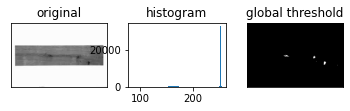

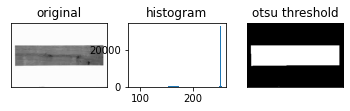

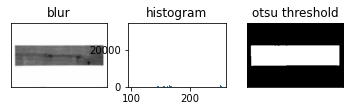

In [788]:
img = cv.imread("images/wood_planck.jfif", 0)

th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)[1]
th2 = cv.threshold(img,  0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

blur = cv.GaussianBlur(img, (5, 5), 0)
th3 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

imgs = [img, 0, th1,
       img, 0, th2,
       blur, 0, th3]

titles = ("original", "histogram", "global threshold",
         "original", "histogram", "otsu threshold",
         "blur", "histogram", "otsu threshold")

for i in range(3):
    plt.subplot(3, 3, 3*i+1), plt_img(imgs[3*i], title=titles[3*i])
    plt.subplot(3, 3, 3*i+2), plt.hist(imgs[3*i].flatten(), 256),
    plt.title(titles[3*i+1])
    plt.subplot(3, 3, 3*i+3), plt_img(imgs[3*i+2], title=titles[3*i+2])
    
    plt.show()

## Morphological Operations
1. Erosion
    - looks for neighbour of anchor point and changes from 255 to 0 (most centre point)
2. Dilation
     - looks for neighbour of anchor point and changes from 0 to 255 (most centre point)
3. Opening (Erosion + Dilation)
    - good for removing small white spots (noise)
    - purpose: break join
4. Closing (Dilation + Erosion)
    - purpose: fill in small hole

In [789]:
# kernel
kernel = np.ones((3, 3), np.uint8)

# erosion
erosion = cv.erode(th3, kernel, iterations=1)

# combined
img_combined = np.hstack((th3, erosion))

show_img("erosion", img_combined)

In [790]:
#trackbar: function and while loop
def nothing(x):
    pass

wn = "window"
cv.namedWindow(wn)
cv.createTrackbar("size", wn, 3, 10, nothing)
cv.createTrackbar("iter", wn, 3, 10, nothing)

while(1):
    # retrieve the size and # iteration
    size = cv.getTrackbarPos("size", wn)
    if size < 3:
        size = 3
        
    iteration = cv.getTrackbarPos("iter", wn)
    if iteration < 1:
        iteration = 1
        
    kernel = np.ones((size, size), dtype=np.uint8)
    #closing
    closing = cv.morphologyEx(th3, cv.MORPH_OPEN, kernel, iterations=iteration)
    
    cv.imshow(wn, closing)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
        
cv.destroyAllWindows()

In [70]:
cv.getStructuringElement(cv.MORPH_ELLIPSE, (9, 9))

array([[0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=uint8)

## Color spaces
- RGB / BGR (prevalent image formats)
- HSV (hue, saturation, value)
    * hue encodes color (angular, 0-360). In OpenCV, 0-179
    * saturation implies color purity (higher the value, purer the color)
    * value: brightness. 0 is dark. (higher the value, brighter it is)
- L\*a\*b
    - L denotes brightness / luminance while a and b are color channels.
    - perceptual uniformity

In [4]:
# sharpen
img = cv.imread("images/lena.jfif")

img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)

l, a, b = cv.split(img_lab)

# process just the L channel
# sharpen
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
l_sharpen = cv.filter2D(1, -1, kernel)

# merge
sharpen = cv.merge((l_sharpen, a, b))

#change to bgr
sharpen = cv.cvtColor(sharpen, cv.COLOR_Lab2BGR)

cv.imshow("original", img)
show_img("sharpen", sharpen)

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\merge.dispatch.cpp:129: error: (-215:Assertion failed) mv[i].size == mv[0].size && mv[i].depth() == depth in function 'cv::merge'


## Demo on color based segmentation

In [74]:
img = cv.imread("images/color_space/pant.jfif")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

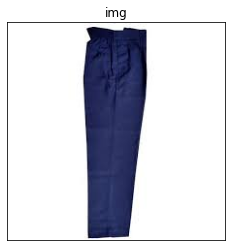

In [75]:
plt_img(img, "img")

In [76]:
## imort dependencies
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

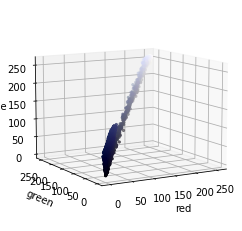

In [79]:
# split the image into separate channels
r, g, b = cv.split(img)
#set up 3D figure
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

# pixel colors ready as argument for scatter plot
pixel_colors = img.reshape((-1, 3))
norm = colors.Normalize()
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.ravel(), g.ravel(), b.ravel(),
            facecolors = pixel_colors, marker=".")
axis.view_init(elev=10, azim=240)
axis.set_xlabel("red")
axis.set_ylabel("green")
axis.set_zlabel("blue")
plt.show()

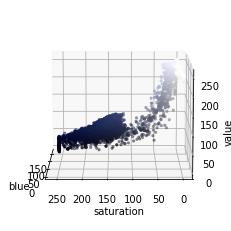

In [87]:
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

h, s, v = cv.split(img_hsv)
#set up 3D figure
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.ravel(), s.ravel(), v.ravel(),
            facecolors = pixel_colors, marker=".")
axis.view_init(elev=10, azim=180)
axis.set_xlabel("blue")
axis.set_ylabel("saturation")
axis.set_zlabel("value")
plt.show()

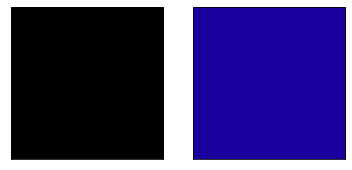

In [131]:
blue_low = (85, 90, 0)
blue_high = (125, 255, 160)

square1 = np.full((10, 10, 3), blue_low, dtype=np.uint8)
square2 = np.full((10, 10, 3), blue_high, dtype=np.uint8)

plt.subplot(121), plt_img(cv.cvtColor(square1, cv.COLOR_HSV2RGB))
plt.subplot(122), plt_img(cv.cvtColor(square2, cv.COLOR_HSV2RGB))
plt.show()

(<Axes: title={'center': 'segmentation results'}>, None)

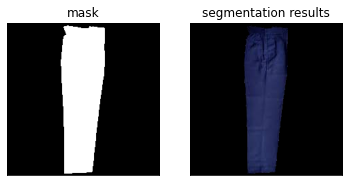

In [89]:
# color based segmentation
mask = cv.inRange(img_hsv, blue_low, blue_high)
res = cv.bitwise_and(img, img, mask=mask)
plt.subplot(121), plt_img(mask, title="mask")
plt.subplot(122), plt_img(res, title="segmentation results")

## Exercise
Does the segmentation generalize to other blue pant images?
- Import all blue pant images ("pant1.jfif" - "pant5.jfif")
- Perform color segmentation
- Display the results

The results should be as shown below:


In [93]:
# define a color segmentation function
def color_seg(img, color_low, color_high, smooth=True):
    """Args:
    img:source image
    color_low and color_high are tuple of colors
    smooth is boolean (blurring or not)"""
    
    ori_img = img.copy()
    if smooth:
        img = cv.GaussianBlur(img, (5, 5), 0)
        
    # change from RGB to HSV
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    
    #mask
    mask = cv.inRange(img_hsv, color_low, color_high)
    mask = cv.erode(mask, None, iterations=2)
    mask = cv.dilate(mask, None, iterations=2)
    
    return cv.bitwise_and(ori_img, ori_img, mask=mask)

# image list(append all images into this list)
imgs = []

for i in range(1, 6):
    img = cv.imread(cv.samples.findFile(f"images/color_space/pant{i}.jfif"))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)
    
#perform color segmentation
# result list
res = [color_seg(im, blue_low, blue_high) for im in imgs]

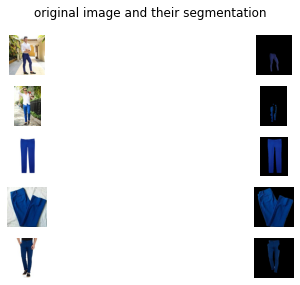

In [94]:
fig, ax = plt.subplots(5, 2, figsize=(10, 4))

for i in range(5):
    ax[i][0].imshow(imgs[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(res[i])
    ax[i][1].axis("off")

fig.suptitle("original image and their segmentation")
plt.tight_layout()
plt.show()

## Weekly Activity

### Question 1
Write a program to segment the boat and the people on it from the background. Follow the instruction below:
- Use 'boat.jpg' as input.
- Apply Otsu thresholding.
- Draw bounding box to identify the region where the boat and people are located.

In [2]:
#global thresholding
[i for i in dir(cv) if i.startswith("THRESH")]

['THRESH_BINARY',
 'THRESH_BINARY_INV',
 'THRESH_MASK',
 'THRESH_OTSU',
 'THRESH_TOZERO',
 'THRESH_TOZERO_INV',
 'THRESH_TRIANGLE',
 'THRESH_TRUNC']

In [129]:
# Load image in grayscale
img = cv.imread("images/boat.jpg", 0)

# show_img("original", img)

# render darker regions to become lighter and apply Otsu thresholding
_, th_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)

blur = cv.blur(img, (12, 12), 0)
_, th_img = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)

# find contours (boat and people)
contours, _ = cv.findContours(th_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# draw bounding boxes around contours
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    #draw bounding box
    cv.rectangle(img, (x, y), (x+w, y+h), None, 4, cv.LINE_AA)

show_img("segmented & bounded", img)

### Question 2
Write a program to visualize the effect of size of structuring element on the morphological transformation (e.g. erosion, dilation, opening, and closing).

- Load the 'leaf.jfif' and perform thresholding to segment the leaf from the background.
- Create a GUI containing trackbar to control the size of structuring element and display the resulting image on a window alongside the trackbar.

In [987]:
import matplotlib.pyplot as plt

In [796]:
#load img
img = cv.imread("images/leaf.jfif", 0)

#thresholding
_, th = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)

In [808]:
def nothing(x):
    pass

wn = "window"
cv.namedWindow(wn)

# create trackbars
cv.createTrackbar("size", wn, 3, 10, nothing)

cv.createTrackbar("iter", wn, 3, 10, nothing)

while(1):
    # retrieve the size and # iteration
    size = cv.getTrackbarPos("size", wn)
    if size < 3:
        size = 3
        
    iteration = cv.getTrackbarPos("iter", wn)
    if iteration < 1:
        iteration = 1
    
    kernel = np.ones((size, size), np.uint8)
    
    # morphological operations
    # 1: Erosion
    erosion = cv.erode(th, kernel, iterations=iteration)
    # 2: Dilation
    dilation = cv.dilate(th, kernel, iterations=iteration)
    # 3: Opening
    opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel, iterations=iteration)
    # 4: Closing
    closing = cv.morphologyEx(th, cv.MORPH_CLOSE, kernel, iterations=iteration)
    
    # stack all the morphological operations in a row
    res = np.hstack((erosion, dilation, opening, closing))
    
    cv.imshow(wn, res)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
        
cv.destroyAllWindows()

### Question 3
Apply the steps shown in exercise 4 to segment the porcelain from these images: "porcelain1.jfif" - "porcelain5.jfif".

In [43]:
# color settings
blue_low = (85, 90, 0)
blue_high = (125, 255, 160)

white_low = (30, 0, 60)
white_high = (255, 70, 255)

In [44]:
# color segmentation function
def color_seg(img, color1_low, color1_high, color2_low, color2_high, smooth=True):
    ori_img = img.copy()
    if smooth:
        img = cv.GaussianBlur(img, (5,5), 0)
        
    # convert from RGB to HSV
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    
    # masks
    mask_color1 = cv.inRange(img_hsv, color1_low, color1_high)
    mask_color1 = cv.erode(mask_color1, None, iterations=2)
    mask_color1 = cv.dilate(mask_color1, None, iterations=2)
    
    mask_color2 = cv.inRange(img_hsv, color2_low, color2_high)
    mask_color2 = cv.erode(mask_color2, None, iterations=1)
    mask_color2 = cv.dilate(mask_color2, None, iterations=5)
    
    # combine both masks
    mask_comb = cv.bitwise_or(mask_color1, mask_color2)
    
    return cv.bitwise_and(ori_img, ori_img, mask=mask_comb)

imgs = []

for i in range(1, 6):
    img = cv.imread(cv.samples.findFile(f"images/color_space/porcelain{i}.jfif"))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)
    
# result list
res = [color_seg(im, blue_low, blue_high, white_low, white_high) for im in imgs]

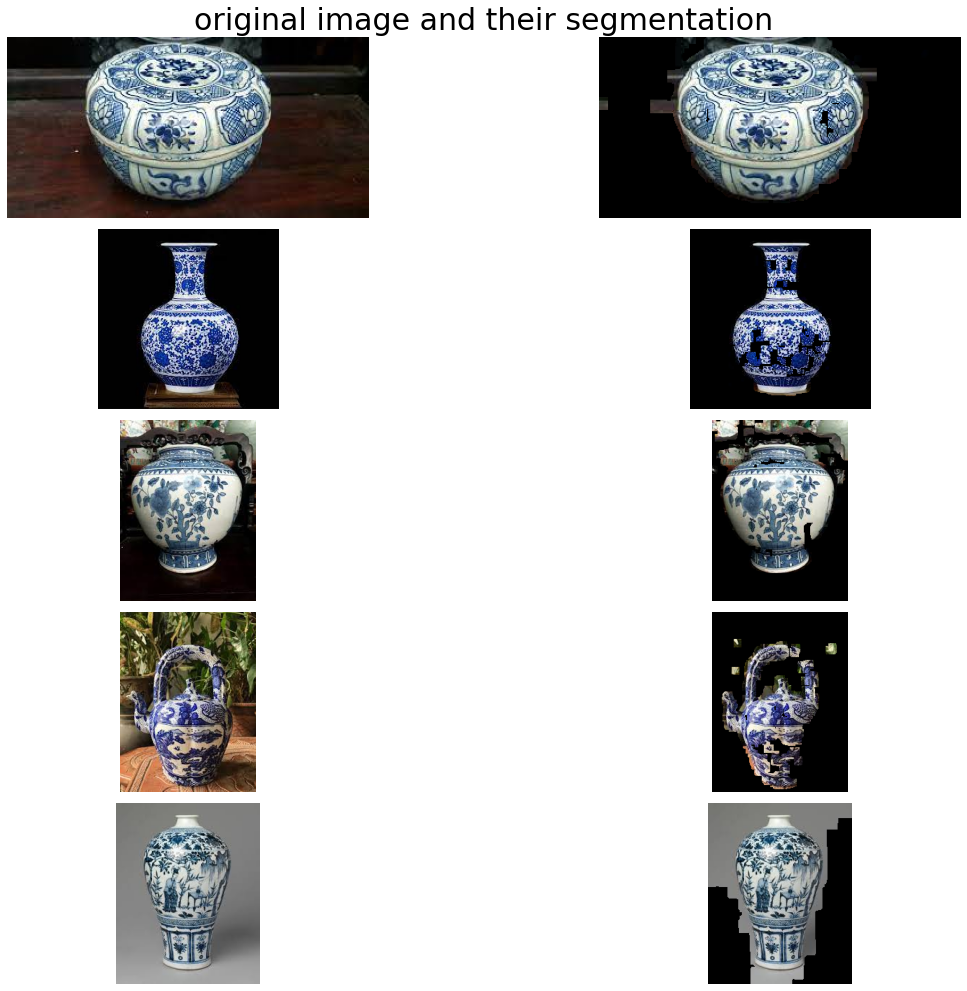

In [45]:
fig, ax = plt.subplots(5, 2, figsize=(20, 14))

for i in range(5):
    ax[i][0].imshow(imgs[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(res[i])
    ax[i][1].axis("off")
    
fig.suptitle("original image and their segmentation", fontsize=30)
plt.tight_layout()
plt.show()